<a href="https://colab.research.google.com/github/WoobeenJeong/bioinfo1_jwb/blob/main/Project_005.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1) Data mounting**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**2) Environment setting**

In [ ]:
!git clone https://github.com/hyeshik/colab-biolab.git
!cd colab-biolab && bash tools/setup.sh
exec(open('colab-biolab/tools/activate_conda.py').read())

In [ ]:
!conda install -y bedtools bioawk samtools

**3) Data loading & check**

In [ ]:
%cd /content/drive/MyDrive/binfo1-work

/content/drive/MyDrive/binfo1-work


In [ ]:
!ls -al /content/drive/MyDrive/binfo1-work/

In [ ]:
!md5sum /content/drive/MyDrive/binfo1-work/*

**4) Background setting**

In [ ]:
%cd /content/drive/MyDrive/binfo1-work
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from collections import Counter

/content/drive/MyDrive/binfo1-work


**5) Target region on CLIP-seq using gencode.gtf**

먼저 GTF파일은 genecode로부터 M32버전이 (2023.02월에) 나왔으며  
M32(GRCm39) Refseq 자료 중 chr9에 대해 확인 할 것  
NCBI RefSeq에서도 Mus musculus strain C57BL/6J chromosome 9, GRCm39 존재

1) C=Shannon’s entrophy를 CRES: Crosslinking-induced reverse transcription error score로 가져감  
2) 이때, insertion은 무시 substitution과 deletion고려  
3) FDR은 permutation으로 구함   
4) Read는 rRNA,tRNA,adapte제외하고 GSNAP의 Refseq에 align  
5) 이를 바탕으로, 먼저 CRES(0.8) 상 low depth positio이 130 reads 이하  
6) LOESS smoothing (regression) a=0.5사용 medium depth positon 250 read이하  
7) FDR(0.001)상 high depth position >250 read 사용  

In [ ]:
!gzip -d gencode.vM32.annotation.gtf.gz

gzip: gencode.vM32.annotation.gtf.gz: No such file or directory


In [ ]:
!grep 'chr9' gencode.vM32.annotation.gtf > gencode.vM32.chr9.gtf

In [ ]:
!head gencode.vM32.chr9.gtf

In [ ]:
!awk -F'\t' '{if ($3 == "gene") print $4}' gencode.vM32.chr9.gtf | sort -n | head -n 1
!awk -F'\t' '{if ($3 == "gene") print $5}' gencode.vM32.chr9.gtf | sort -n | tail -n 1

3038669
124252776


In [ ]:
!samtools view -b -o CLIP-let7g.bam CLIP-35L33G.bam chr9:3038669-124252776
!samtools view CLIP-let7g.bam | wc -l

1696165


In [ ]:
!samtools index CLIP-let7g.bam

In [ ]:
!samtools view -F 16 CLIP-let7g.bam | wc -l

905001


(+)stand만 추출, 절반이 사라짐

In [ ]:
!samtools view -b -F 0x10 -o forward-CLIP-let7g.bam CLIP-let7g.bam

In [ ]:
!samtools view -f 16 forward-CLIP-let7g.bam  | wc -l

0


In [ ]:
!samtools view -F 16 forward-CLIP-let7g.bam  | wc -l

905001


QC는 상관없을 것으로 생각되나, secondary와 supplimentary read는 제거해야함 = secondary는 하나의 서열이 다른 곳에도 mapping될 수 있음을 고려, 

In [ ]:
!samtools flagstat forward-CLIP-let7g.bam | head

905001 + 0 in total (QC-passed reads + QC-failed reads)
339889 + 0 secondary
189 + 0 supplementary
0 + 0 duplicates
905001 + 0 mapped (100.00% : N/A)
0 + 0 paired in sequencing
0 + 0 read1
0 + 0 read2
0 + 0 properly paired (N/A : N/A)
0 + 0 with itself and mate mapped


In [ ]:
!samtools view -b -F 0x900 -o first-forward-CLIP-let7g.bam forward-CLIP-let7g.bam

In [ ]:
!samtools view -F 16 first-forward-CLIP-let7g.bam  | wc -l

564923


estimate가 0.001 이었으니, MAPQ가 30이다.

In [ ]:
!samtools view -q 30 -b first-forward-CLIP-let7g.bam -o check-CLIP-let7g.bam
!wc -l check-CLIP-let7g.bam

73508 check-CLIP-let7g.bam


In [ ]:
!samtools mpileup check-CLIP-let7g.bam 2>/dev/null > check-CLIP-let7g.pileup
!wc -l check-CLIP-let7g.pileup

18224608 check-CLIP-let7g.pileup


In [ ]:
!awk '$2 >= 3038669 && $2 <= 124252714 { print $0; }' check-CLIP-let7g.pileup > check-CLIP-let7g-gene.pileup
!tail -n 2 check-CLIP-let7g-gene.pileup

chr9	124220663	N	1	C	2
chr9	124220664	N	1	T$	2


In [ ]:
pileup = pd.read_csv('check-CLIP-let7g-gene.pileup', sep='\t', names=['chrom', 'pos', 'ref', 'count', 'basereads', 'quals'])
pileup.tail()

,chrom,pos,ref,count,basereads,quals
18224603,chr9,124220660,N,1,C,@
18224604,chr9,124220661,N,1,C,C
18224605,chr9,124220662,N,1,C,C
18224606,chr9,124220663,N,1,C,2
18224607,chr9,124220664,N,1,T$,2


count의 개수가 최대 / 최소 얼마이고 볼 만한 수준인지 확인

In [ ]:
len(np.unique(pileup['count']))

1740

In [ ]:
pileup['count'].describe()

count    1.822461e+07
mean     1.073809e+01
std      4.920374e+01
min      0.000000e+00
25%      2.000000e+00
50%      4.000000e+00
75%      8.000000e+00
max      7.994000e+03
Name: count, dtype: float64

위를 보면 알수 있듯이 한 75%까지는 10개정도만 count되어 있는데, 무려 7993 read가 count되는 경우도 있음.  
이경우는 좀 궁금하긴 하다만, 너무 크기 때문에, threshold <=50 reads로 두고 진행   
(Shannon에서 depth 50으로 했으므로)

In [ ]:
f50pileup = pileup[pileup['count'] > 50]

In [ ]:
len(np.unique(f50pileup['count']))

1689

In [ ]:
len(np.unique(f50pileup['pos']))

534478

In [ ]:
f50pileup['count'].describe()

count    534478.000000
mean        140.538063
std         251.364587
min          51.000000
25%          58.000000
50%          72.000000
75%         108.000000
max        7994.000000
Name: count, dtype: float64

In [ ]:
max(f50pileup['pos']),min(f50pileup['pos'])

(123421315, 3359542)

match와 substitution, deletion을 사용할 것이므로, 나머지에 해당하는 tag들은 제거.  
**여기서 Deletion은 포함하는 경우를 고려하는 것을 고민할 것**

In [ ]:
toremove = re.compile(r'[<>$*#+-]|[0-9]|\^.')
f50pileup.loc[:, 'matches'] = f50pileup['basereads'].apply(lambda x: toremove.sub('', x))

<ipython-input-15-f5adc2352889>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f50pileup.loc[:, 'matches'] = f50pileup['basereads'].apply(lambda x: toremove.sub('', x))


In [ ]:
f50pileup[['chrom', 'pos', 'matches']].head()

,chrom,pos,matches
21616,chr9,3359542,GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG...
21617,chr9,3359543,GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG...
21618,chr9,3359544,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...
21619,chr9,3359545,GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG...
21620,chr9,3359546,TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT...


Deletion상관 없이 Insertion하고 Hard-clipped read만 제외

In [ ]:
#f50pileup['base_count'] = f50pileup['matches'].apply(lambda x: len([c for c in x if c != 'H' and c != 'I']))
#f50pileup.head()

In [ ]:
import itertools

column = f50pileup['matches']
components = column.str.findall('[A-Za-z0-9]') 
all_components = list(itertools.chain(*components))
unique_components = set(all_components)

print(unique_components)

{'T', 'C', 'A', 'N', 'G'}


In [ ]:
f50pileup['base_count'] = f50pileup['matches'].apply(lambda x: len([c for c in x if c.upper() in ('A', 'T', 'G', 'C')]))
f50pileup.head()

<ipython-input-18-dc38196e0fd8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f50pileup['base_count'] = f50pileup['matches'].apply(lambda x: len([c for c in x if c.upper() in ('A', 'T', 'G', 'C')]))


,chrom,pos,ref,count,basereads,quals,matches,base_count
21616,chr9,3359542,N,51,GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG...,HDEIHIIGIIIHHIIGAIIIGIBGIHBFGIHE?GIGIHGGHHIBII...,GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG...,51
21617,chr9,3359543,N,51,GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG...,IGEIHFG@IIIHHHIGFHIIEIBHIH;GGIHH=GIEIHIGHHIGII...,GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG...,51
21618,chr9,3359544,N,51,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...,IHBIHIIDHGIGHIIIDIIIDH0HH?DEHFHBBGIGIHIGHHDAII...,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...,51
21619,chr9,3359545,N,51,GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG...,IH8IHIIEIGIGHIIFFIIIGI=HIHDGGIHI;GHIIGHGHHI4DI...,GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG...,51
21620,chr9,3359546,N,51,TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT...,IHEIHHIEIGGDHIIDHIIIGI7HIH>GHIHI<GIGIFIGDHFCII...,TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT...,51


In [ ]:
np.unique(f50pileup['base_count'])

array([   0,    1,    2, ..., 7989, 7990, 7994])

Colab RAM사용 제한 상, 데이터가 날라가는 것을 방지하기 위해 일단 결과 csv 저장

In [ ]:
f50pileup.head()

,chrom,pos,ref,count,basereads,quals,matches,base_count
21616,chr9,3359542,N,51,GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG...,HDEIHIIGIIIHHIIGAIIIGIBGIHBFGIHE?GIGIHGGHHIBII...,GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG...,51
21617,chr9,3359543,N,51,GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG...,IGEIHFG@IIIHHHIGFHIIEIBHIH;GGIHH=GIEIHIGHHIGII...,GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG...,51
21618,chr9,3359544,N,51,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...,IHBIHIIDHGIGHIIIDIIIDH0HH?DEHFHBBGIGIHIGHHDAII...,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...,51
21619,chr9,3359545,N,51,GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG...,IH8IHIIEIGIGHIIFFIIIGI=HIHDGGIHI;GHIIGHGHHI4DI...,GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG...,51
21620,chr9,3359546,N,51,TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT...,IHEIHHIEIGGDHIIDHIIIGI7HIH>GHIHI<GIGIFIGDHFCII...,TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT...,51


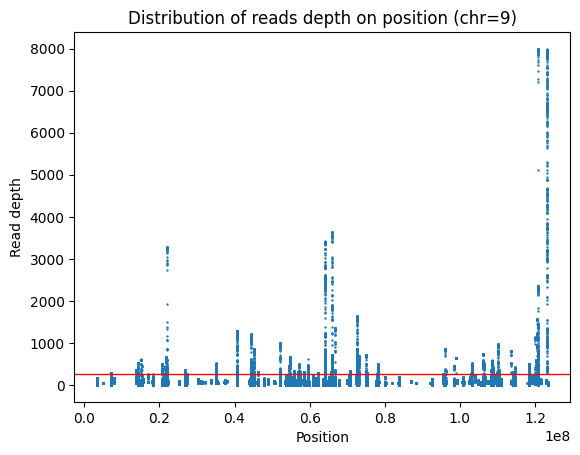

In [ ]:
x = f50pileup['pos']
y = f50pileup['base_count']

plt.scatter(x, y,s=0.5)
plt.xlabel('Position')
plt.ylabel('Read depth')
plt.title('Distribution of reads depth on position (chr=9)')
plt.axhline(250, c='red', linewidth=1)
plt.show()

In [ ]:
pup = f50pileup[(f50pileup['base_count'] <250)&(f50pileup['base_count'] >50)]

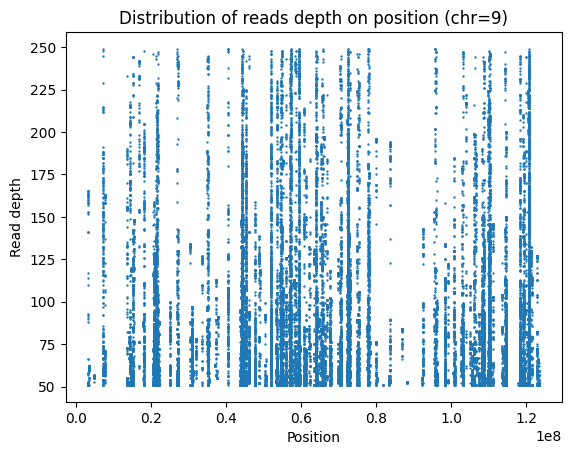

In [ ]:
x = pup['pos']
y = pup['base_count']
plt.scatter(x, y,s=0.5)
plt.xlabel('Position')
plt.ylabel('Read depth')
plt.title('Distribution of reads depth on position (chr=9)')
plt.show()

In [ ]:
pup = f50pileup[(f50pileup['base_count'] < 250) & (f50pileup['base_count'] > 50)]

In [ ]:
pup['matches'].apply(len)

21616       51
21617       51
21618       51
21619       51
21620       51
            ..
18081219    51
18081221    51
18081222    51
18081223    51
18081224    57
Name: matches, Length: 40671, dtype: int64

한 position에 A,T,G,C가 존재하므로, 확률은 
S={A,T,G,C,N}
p(A), p(T), p(G), p(C) 을 구해서 shannon entropy를 구해야 한다.

In [ ]:
for pos, row in pup.iterrows():
    if row['base_count'] == 0:
        pup.loc[pos,'countA'] = '0'
        pup.loc[pos,'countT'] = '0'
        pup.loc[pos,'countG'] = '0'
        pup.loc[pos,'countC'] = '0'
    else:
        pup.loc[pos,'countA'] = (row['matches'].count('A'))/row['base_count']
        pup.loc[pos,'countT'] = (row['matches'].count('T'))/row['base_count']
        pup.loc[pos,'countG'] = (row['matches'].count('G'))/row['base_count']
        pup.loc[pos,'countC'] = (row['matches'].count('C'))/row['base_count']

In [ ]:
pup[['countA', 'countT', 'countG', 'countC']].head()

,countA,countT,countG,countC
21616,0.0,0.0,1.0,0.0
21617,0.0,0.0,1.0,0.0
21618,1.0,0.0,0.0,0.0
21619,0.0,0.0,1.0,0.0
21620,0.0,1.0,0.0,0.0


In [ ]:
pup['shannon'] = np.zeros(len(pup))

for i, row in pup.iterrows():
    countA = float(row['countA'])
    countT = float(row['countT'])
    countG = float(row['countG'])
    countC = float(row['countC'])
    
    if countA <= 0.0 or countA >= 1.0:
        pup.loc[i, 'shannon'] += 0
    else:
        pup.loc[i, 'shannon'] += countA * np.log2(countA)
    
    if countT <= 0.0 or countT >= 1.0:
        pup.loc[i, 'shannon'] += 0
    else:
        pup.loc[i, 'shannon'] += countT * np.log2(countT)
    
    if countG <= 0.0 or countG >= 1.0:
        pup.loc[i, 'shannon'] += 0
    else:
        pup.loc[i, 'shannon'] += countG * np.log2(countG)
    
    if countC <= 0.0 or countC >= 1.0:
        pup.loc[i, 'shannon'] += 0
    else:
        pup.loc[i, 'shannon'] += countC * np.log2(countC)


In [ ]:
pup[['countA', 'countT', 'countG', 'countC','shannon']].head()

,countA,countT,countG,countC,shannon
21616,0.0,0.0,1.0,0.0,0.0
21617,0.0,0.0,1.0,0.0,0.0
21618,1.0,0.0,0.0,0.0,0.0
21619,0.0,0.0,1.0,0.0,0.0
21620,0.0,1.0,0.0,0.0,0.0


In [ ]:
pup['shannon']=-pup['shannon']

In [ ]:
np.unique(pup['shannon'])

array([-0.        ,  0.03775019,  0.03787895, ...,  1.8217662 ,
        1.82363023,  1.87345501])

In [ ]:
pup['shannon'].describe()

count    40671.000000
mean         0.053671
std          0.189090
min         -0.000000
25%         -0.000000
50%          0.000000
75%         -0.000000
max          1.873455
Name: shannon, dtype: float64

In [ ]:
grouped = pup.groupby('pos')['shannon'].sum().reset_index() 

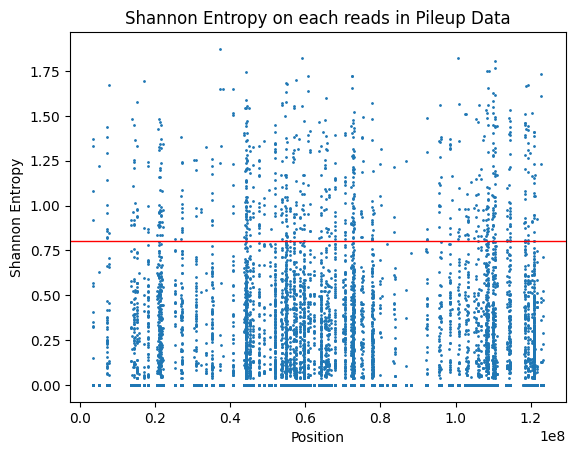

In [ ]:
plt.scatter(grouped['pos'], grouped['shannon'],s=1)
plt.xlabel('Position')
plt.ylabel('Shannon Entropy')
plt.title('Shannon Entropy on each reads in Pileup Data')
plt.axhline(0.8, c='red', linewidth=1)
plt.show()

In [ ]:
import collections
from scipy.stats import entropy

def shannon(seq):
    tmp = collections.Counter([tmp_base for tmp_base in seq])
    dist = [x/sum(tmp.values()) for x in tmp.values()]
    result = entropy(dist, base=2)
    return result

<ipython-input-65-84df57a27493>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pup2['shannon'] = pup2['matches'].map(lambda x : shannon(x))


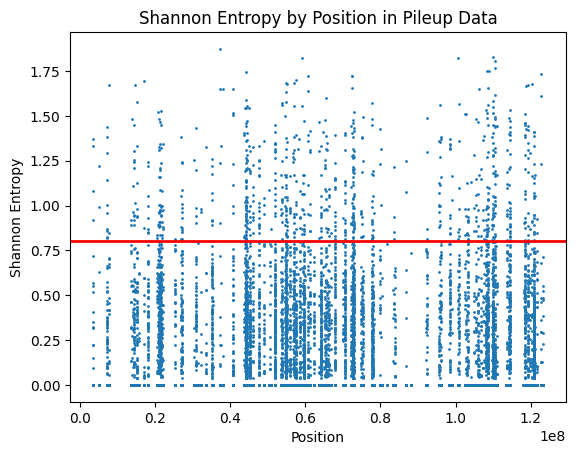

In [ ]:
pup2 = pup
pup2['shannon'] = pup2['matches'].map(lambda x : shannon(x))
plt.scatter(pup2['pos'], pup2['shannon'],s=1)
plt.xlabel('Position')
plt.ylabel('Shannon Entropy')
plt.title('Shannon Entropy by Position in Pileup Data')
plt.axhline(0.8, c='red', linewidth=2)
plt.show()

In [ ]:
subpup = pup[(pup['shannon'] > 0.8)]

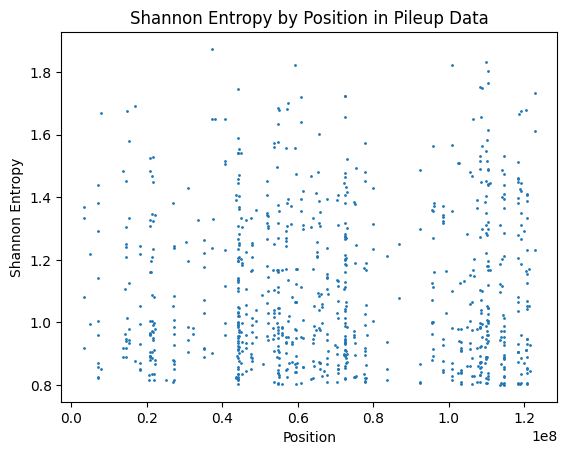

In [ ]:
plt.scatter(subpup['pos'], subpup['shannon'],s=1)
plt.xlabel('Position')
plt.ylabel('Shannon Entropy')
plt.title('Shannon Entropy by Position in Pileup Data')
plt.show()

In [ ]:
subpup = pup[(pup['shannon'] > 0.2)]

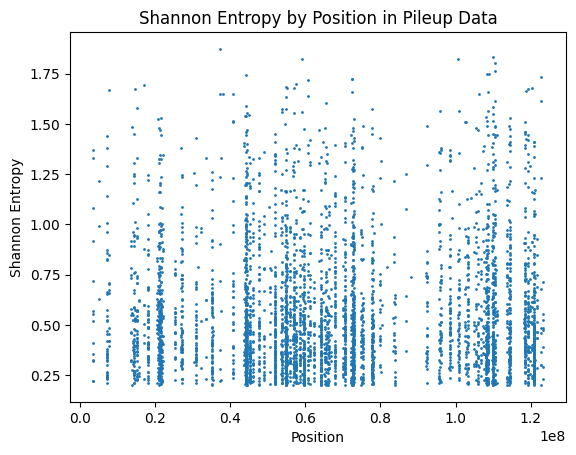

In [ ]:
plt.scatter(subpup['pos'], subpup['shannon'],s=1)
plt.xlabel('Position')
plt.ylabel('Shannon Entropy')
plt.title('Shannon Entropy by Position in Pileup Data')
plt.show()

In [ ]:
subpup['adj_shannon'] = (subpup['shannon']/subpup['base_count'])*subpup['base_count']

np.unique(subpup['adj_shannon']-subpup['shannon'])

In [ ]:
min(subpup['pos']), max(subpup['pos'])

(3359552, 122836478)

In [ ]:
# threshold = 1000

# diff = subpup['pos'].diff()
# group_indices = np.where(diff > threshold)[0]
# groups = np.split(subpup['pos'], group_indices + 1)

# num_components_list = []
# sum_diff_list = []
# min_pos_list = []
# max_pos_list = []

# for group in groups:
#     num_components = len(group)
#     sum_diff = group.diff().sum()
#     min_pos = group.min()
#     max_pos = group.max()

#     num_components_list.append(num_components)
#     sum_diff_list.append(sum_diff)
#     min_pos_list.append(min_pos)
#     max_pos_list.append(max_pos)

# result = {
#     'Numbers': num_components_list,
#     'Differences': sum_diff_list,
#     'Min Pos': min_pos_list,
#     'Max Pos': max_pos_list
# }
# result=pd.DataFrame(result)

# result=result[(result['Numbers']>10) & (result['Differences']!=0)]
# result=result.sort_values('Differences')
# result.head(n=15)

,Numbers,Differences,Min Pos,Max Pos
81,12,1242.0,27264897.0,27266139.0
199,12,1411.0,57437547.0,57438958.0
216,13,1528.0,59576222.0,59577750.0
316,15,1667.0,72642370.0,72644037.0
5,12,1971.0,7186783.0,7188754.0
85,19,2169.0,30980341.0,30982510.0
546,11,2240.0,120781990.0,120784230.0
112,11,2354.0,44319016.0,44321370.0
144,11,2500.0,51976182.0,51978682.0
173,19,2543.0,54816035.0,54818578.0


In [ ]:
subpup.to_csv('subpup2.csv', index=True) #0.2

In [ ]:
subpup.to_csv('subpup.csv', index=True) #0.8

In [172]:
%cd /content/drive/MyDrive/binfo1-work
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from collections import Counter

/content/drive/MyDrive/binfo1-work


In [178]:
subpup = pd.read_csv('subpup2.csv')

In [ ]:
start = 3038669
end = 124252776

subpup_sorted = set(subpup['pos'])

with open('subpup_regions.csv', 'w') as f:
    f.write('Start,End,Length\n')

    missing_start = None
    missing_end = None
    for pos in range(start, end + 1):
        if pos not in subpup_sorted:
            if missing_start is None:
                missing_start = pos
            missing_end = pos
        elif missing_start is not None:
            length = missing_end - missing_start + 1
            if length >= 15511 and length < 220000:
                f.write(f'{missing_start},{missing_end},{length}\n')
            missing_start = None
            missing_end = None

    if missing_start is not None:
        length = missing_end - missing_start + 1
        if length >= 15511 and length < 220000:
            f.write(f'{missing_start},{missing_end},{length}\n')

In [ ]:
region = pd.read_csv('subpup_regions.csv')
region['Length'] = region['End'] - region['Start'] + 1
region.sort_values(by='Length').head(35)

In [ ]:
region['1e7'] = round(region['Start']/1e7,0)
counts = np.unique(region['1e7'], return_counts=True)
counts = pd.DataFrame(counts)
counts.index = ['1e7','regions']
counts.reset_index(inplace=True)
counts = counts.transpose()
counts.columns = counts.iloc[0]
counts = counts.iloc[1:]
hicounts = counts[counts['regions']>=10]
hicounts.sort_values(by='regions', ascending=False)

index,1e7,regions
10,11.0,29.0
7,7.0,24.0
9,10.0,14.0
6,6.0,12.0


In [ ]:
region[(region['1e7']>10) & (region['1e7']<12) ] 

,Start,End,Length,1e7
89,105532209,105564621,32413,11.0
90,106067025,106092307,25283,11.0
91,106716270,106751272,35003,11.0
92,107447731,107469519,21789,11.0
93,107470072,107644134,174063,11.0
94,108177083,108204797,27715,11.0
95,108217418,108249797,32380,11.0
96,108249799,108269159,19361,11.0
97,108269161,108359082,89922,11.0
98,108392337,108437731,45395,11.0


In [ ]:
# start = 3038669
# end = 124252776
# pos = subpup['pos'].sort_values()

# whole = set(range(start, end+1))

# missing = sorted(list(whole - set(pos)))

# startpos = []
# endpos = []

# for i in range(len(missing)):
#     if i == 0:
#         startpos.append(missing[i])
#     elif missing[i] != missing[i-1] + 1:
#         endpos.append(missing[i-1])
#         startpos.append(missing[i])

# if len(missing) > 0:
#     endpos.append(missing[-1])

# region = pd.DataFrame({
#     'Start': startpos,
#     'End': endpos
# })

# region['Length'] = region['End'] - region['Start'] + 1
# region.head()


106067016	106092310

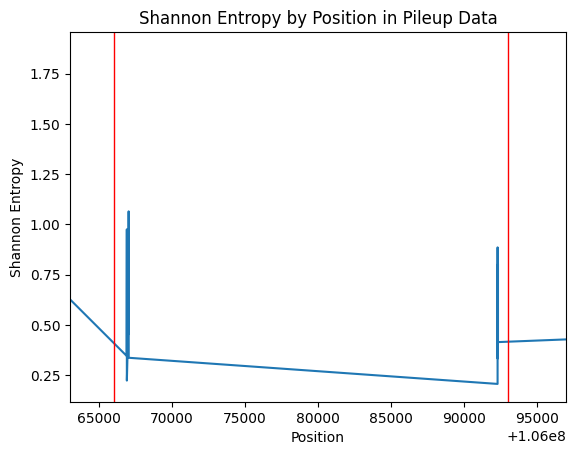

In [188]:
plt.plot(subpup['pos'], subpup['shannon'])
plt.xlabel('Position')
plt.ylabel('Shannon Entropy')
plt.title('Shannon Entropy by Position in Pileup Data')
plt.xlim(106063000,106097000)
plt.axvline(106066000, c='red', linewidth=1)
plt.axvline(106093000, c='red', linewidth=1)
plt.show()

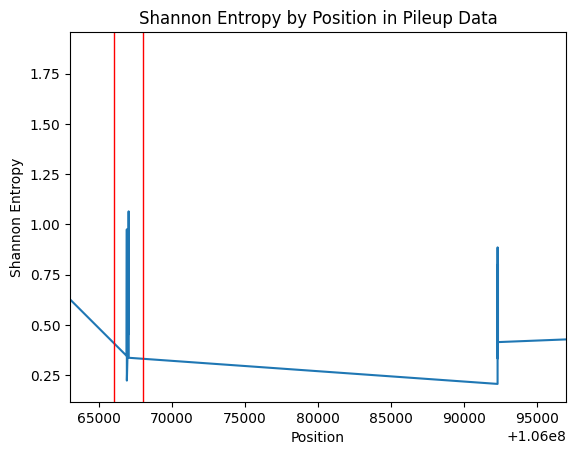

In [190]:
plt.plot(subpup['pos'], subpup['shannon'])
plt.xlabel('Position')
plt.ylabel('Shannon Entropy')
plt.title('Shannon Entropy by Position in Pileup Data')
plt.xlim(106063000,106097000)
plt.axvline(106066000, c='red', linewidth=1)
plt.axvline(106068000, c='red', linewidth=1)
plt.show()

In [ ]:
subpup2 = pup[(pup['pos'] > 106066500) & (pup['pos'] < 106068500)]
len(subpup2)

123

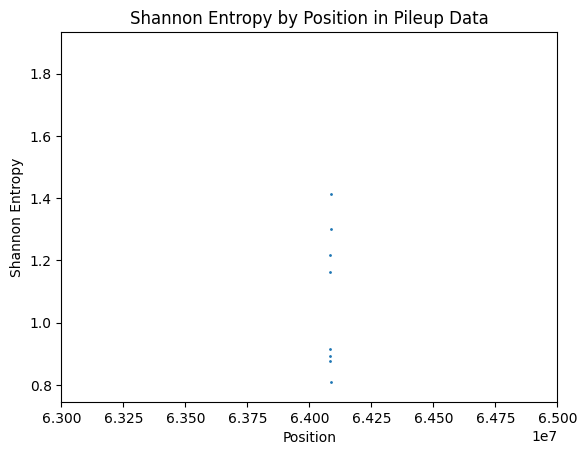

In [ ]:
plt.scatter(subpup['pos'], subpup['shannon'],s=1)
plt.xlabel('Position')
plt.ylabel('Shannon Entropy')
plt.title('Shannon Entropy by Position in Pileup Data')
plt.xlim(63000000,65000000)
plt.show()

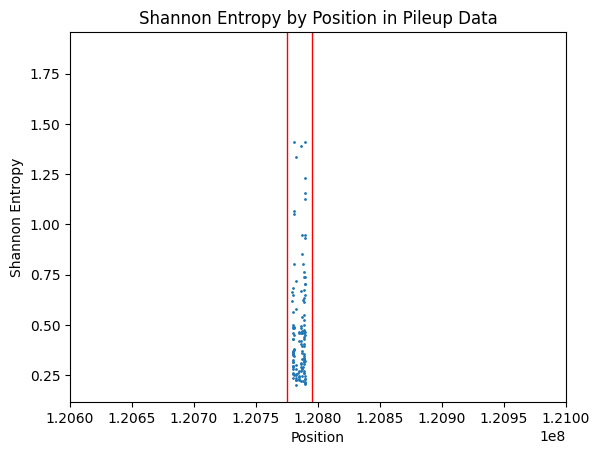

In [ ]:
plt.scatter(subpup['pos'], subpup['shannon'],s=1)
plt.xlabel('Position')
plt.ylabel('Shannon Entropy')
plt.title('Shannon Entropy by Position in Pileup Data')
plt.xlim(120600000,121000000)
plt.axvline(120775000, c='red', linewidth=1)
plt.axvline(120795000, c='red', linewidth=1)
plt.show()

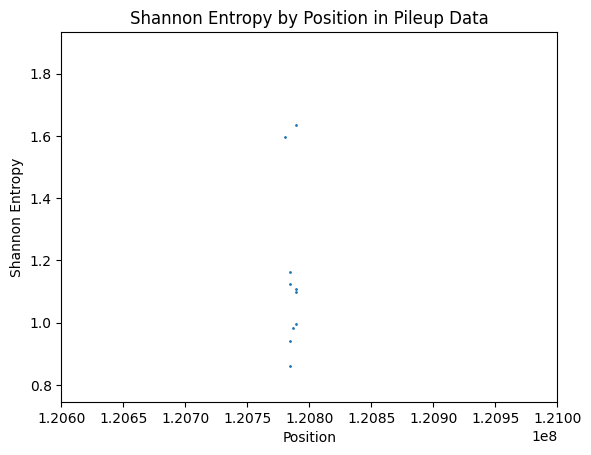

In [ ]:
plt.scatter(subpup['pos'], subpup['shannon'],s=1)
plt.xlabel('Position')
plt.ylabel('Shannon Entropy')
plt.title('Shannon Entropy by Position in Pileup Data')
plt.xlim(120600000,121000000)
plt.show()

In [ ]:
subpup2 = pup[(pup['shannon'] > 0.8) & (pup['pos'] > 1.206e8) & (pup['pos'] < 1.210e8)]
len(subpup2)

15

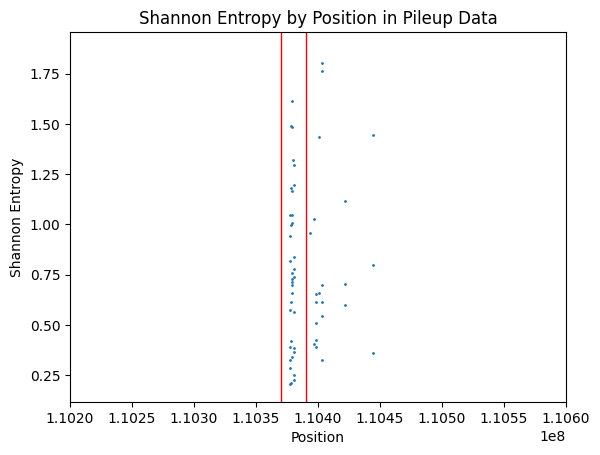

In [ ]:
plt.scatter(subpup['pos'], subpup['shannon'],s=1)
plt.xlabel('Position')
plt.ylabel('Shannon Entropy')
plt.title('Shannon Entropy by Position in Pileup Data')
plt.xlim(110200000,110600000)
plt.axvline(110370000, c='red', linewidth=1)
plt.axvline(110390000, c='red', linewidth=1)
plt.show()

In [ ]:
subpup3 = pup[(pup['shannon'] > 0.8) & (pup['pos'] > 1.1037e8) & (pup['pos'] < 1.1039e8)]
len(subpup3)

15

In [ ]:
subpup2

,chrom,pos,ref,count,basereads,quals,matches,base_count,countA,countT,countG,countC,shannon
17515495,chr9,120780456,N,187,>>>>GGGGGGGGGGGAGGGGAGGGGAGGGAGGAATTTTGTGTTTGT...,GIDDG@3IGHB:G@GIIHIGHHIBHA?IH=DIHHIGIIHIHIIIGH...,GGGGGGGGGGGAGGGGAGGGGAGGGAGGAATTTTGTGTTTGTTGTG...,183,0.103825,0.060109,0.786885,0.049180,1.068908
17515596,chr9,120780557,N,198,>>>>GGGGGGGCGGGG-2NNGCGGAGGCGGGGGGAGGGGGGGGGGG...,GIDDAF@7IIHIHG>DICIGG@HIHEHGGGIBGEBFIBHHFGGGHI...,GGGGGGGCGGGGNNGCGGAGGCGGGGGGAGGGGGGGGGGGGGAACG...,194,0.087629,0.005155,0.845361,0.061856,0.800197
17515609,chr9,120780570,N,192,>>>>GGGGGGGGGGGGGGGGGGAGGGGGGGGGGGGAGGGGGGGGGG...,GIDDIIIDDDH@IGGIHIIHIG?I>GG>DE:IDEBGHHIDGIIGG:...,GGGGGGGGGGGGGGGGGGAGGGGGGGGGGGGAGGGGGGGGGGGGGG...,188,0.186170,0.000000,0.739362,0.074468,1.052670
17515827,chr9,120780788,N,150,>>>>GGGGGGGGGGGGGGGGGGGGGGGGGGGGGAGGGGAGGGGGGG...,GIDDHE@GI=8HDIIIAHIIIIIHHIHBDDBI<IIGIIHFIEAHCE...,GGGGGGGGGGGGGGGGGGGGGGGGGGGGGAGGGGAGGGGGGGGGGG...,146,0.260274,0.061644,0.623288,0.054795,1.407908
17517027,chr9,120781988,N,172,>>>>GAGTGGAATGTGGTAAGTTGTAAAAAAGAAGGGGGGGGGGGG...,GIDDBGDH8<IDGIHFIHEIBII2GIBIBGBGDDBBEEGCGIG=GH...,GAGTGGAATGTGGTAAGTTGTAAAAAAGAAGGGGGGGGGGGGGGGG...,168,0.172619,0.077381,0.690476,0.059524,1.334387
17521665,chr9,120786626,N,105,GGGGGGGAAAAAAAAAAAAAAAAACGGGACGAGCAAGGCCGCGGGC...,8HI@IDGFIBIG1HGD8HGGHIIBBGBHBHGDEGGIDH5DIGIIBC...,GGGGGGGAAAAAAAAAAAAAAAAACGGGACGAGCAAGGCCGCGGGC...,105,0.295238,0.000000,0.561905,0.142857,1.387966
17521759,chr9,120786720,N,123,GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG...,<GIGII<D?HDID@GHHH>IHEIGIH;G@IGIEEIGIE:BH>IAIE...,GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG...,123,0.073171,0.000000,0.821138,0.105691,0.852154
17521938,chr9,120786899,N,240,GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGCGGGGG...,BGEI>?<<IHIICIIEG52HFBEGBB>HAIIBI;@GIIDG@ICHIH...,GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGCGGGGG...,235,0.148936,0.012766,0.795745,0.042553,0.945588
17522737,chr9,120787698,N,221,CCCCCTTCTCTTTCTCTCCCCCCCCCCCCTTTTCCCCCTCTCTTCC...,DFF8DBCDEGGGD?=I;AHGGGGH?6D;EH5H:AIHG?H?ADIGBH...,CCCCCTTCTCTTTCTCTCCCCCCCCCCCCTTTTCCCCCTCTCTTCC...,221,0.000000,0.244344,0.000000,0.755656,0.802190
17524232,chr9,120789196,N,69,GGGGGGGGGGGGGGGGGGGGGGGAAGGGGGGGAGAGGGGAGGAGGA...,H=DDHFIIHIH>H?GGIGIHFBDHCIHHGEEIHDHIIGII=IHHII...,GGGGGGGGGGGGGGGGGGGGGGGAAGGGGGGGAGAGGGGAGGAGGA...,69,0.260870,0.000000,0.724638,0.014493,0.930967


In [ ]:
target = subpup2[['chrom','pos']]
target['start']=subpup2['pos']-16
target['stop']=subpup2['pos']+15
target = target.drop('pos', axis=1)
target['shannon'] = subpup2[['shannon']]
target

<ipython-input-88-361baa628390>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target['start']=subpup2['pos']-16
<ipython-input-88-361baa628390>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target['stop']=subpup2['pos']+15


,chrom,start,stop,shannon
14849219,chr9,106066861,106066892,-0.000000
14849220,chr9,106066862,106066893,-0.000000
14849221,chr9,106066863,106066894,-0.000000
14849222,chr9,106066864,106066895,-0.000000
14849223,chr9,106066865,106066896,0.345117
...,...,...,...,...
14849927,chr9,106067956,106067987,-0.000000
14849928,chr9,106067957,106067988,-0.000000
14849929,chr9,106067958,106067989,0.169324
14849930,chr9,106067959,106067990,-0.000000


In [ ]:
target.to_csv("target_mirlet7g3.bed",header=None, index=False, sep='\t')  

In [ ]:
!bedtools getfasta -fi GRCm39.genome.fa -bed target_mirlet7g3.bed -fo target_mirlet7g3.fa

120780444-120789542

In [ ]:
subpup = pup[(pup['pos'] > 1.207790e8) & (pup['pos'] < 1.207810e8)]
subpup.to_csv('pup.csv', index=True)

In [ ]:
subpup2 = pup[(pup['pos'] > 106066500) & (pup['pos'] < 106068500)]
subpup2.to_csv('pup2.csv', index=True)

In [ ]:
max_columns = subpup2[['countA', 'countT', 'countG', 'countC']].idxmax(axis=1)
column_letters = max_columns.str[-1]
result = ''.join(column_letters)
result

'GTTTGTATTTGAACACTGTGTGTGTCCACTTAAGGGAGAGGGAACCTTGCAGCCAAGAATGACTCTGTGGATAGTGTGTGCCACAACTGTTATTCTTCTCTGTTAAGAAAGAGGGAGAAAGCT'

In [ ]:

substring = 'AAG*G'
start_positions = []

for i in range(len(result) - len(substring) + 1):
    if result[i:i+len(substring)].startswith('AAG') and result[i:i+len(substring)].endswith('G'):
        start_positions.append(i)

# Check if the substring is found
if start_positions:
    print("Substring '", substring, "' found at starting positions:", start_positions)
else:
    print("Substring '", substring, "' not found.")

Substring ' AAG*G ' found at starting positions: [31, 108]
